# модель Rt для COVID‑19 (PyMC 5)  
**Задача:** Россия, Италия, Германия, Франция; период обучения: 01.01.2020–01.12.2020; прогноз: 02.12.2020–14.12.2020.

PyMC5. Данные из OWID
> Для каждой страны игнорируем дни **до первого превышения 100 новых случаев в день**.
>
> В основе — простая дискретная «обновляющаяся» (renewal) модель:  
> \( E[C_t] = R_t \, \sum_{s=1}^S g_s \, C_{t-s} \), где \(g\) — дискретизированное распределение интервалов генерации.  
> \(R_t\) моделируем гауссовским случайным блужданием по лог‑шкале.

**Опорные материалы (для справки в ноутбуке):**
- Systrom, Vladeck, Wiecki (rt.live): байесовская оценка \(R_t\) через renewal‑уравнение.  
- Wiecki, *The Bayesian Workflow: Building a COVID‑19 Model* (PyMC).  
- OWID: `owid-covid-data.csv` (стабильный URL и документация).
- Лекции препода: гамма‑интервал генерации со средним ~6.5 дней (shape=2.6, rate=0.4).

**Параметры по умолчанию:** интервал генерации \(g\) ~ Gamma(shape=2.6, rate=0.4) дискретизуем по дням 1..21 и нормируем.

In [1]:
!pip -q install pymc==5.* arviz pandas numpy matplotlib scipy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy.stats import gamma
from datetime import datetime

plt.rcParams['figure.figsize'] = (9, 4)
RNG = np.random.default_rng(42)


# загрузка и предобработка

In [3]:
# Загружаем OWID
OWID_URL = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/full_data.csv"

df = pd.read_csv(OWID_URL, usecols=["location","date","new_cases"])
df["date"] = pd.to_datetime(df["date"])
df["new_cases"] = df["new_cases"].clip(lower=0).fillna(0.0)

countries = ["Russia", "Italy", "Germany", "France"]

# границы периодов
start_fit = pd.Timestamp("2020-01-01")
end_fit   = pd.Timestamp("2020-12-01")
start_fc  = pd.Timestamp("2020-12-02")
end_fc    = pd.Timestamp("2020-12-14")

def take_country_series(df, country):
    d = df[df.location.eq(country)].copy()
    d = d[(d.date >= start_fit) & (d.date <= end_fit)]
    # Отбрасываем дни до первого >100
    idx = d.index[d["new_cases"] > 100]
    if len(idx) == 0:
        raise ValueError(f"No days >100 for {country}")
    d = d.loc[idx[0]:].reset_index(drop=True)
    # смягчить выходные
    d["cases_smooth"] = d["new_cases"].rolling(7, min_periods=1).mean()
    return d

series = {c: take_country_series(df, c) for c in countries}

# фактические данные у прогноза
df_real = (df[df.location.isin(countries) & (df.date>=start_fc) & (df.date<=end_fc)]
           .copy().sort_values(["location","date"]))


# интервал генерации и вспомогательные функции

In [4]:
# дискретизация гамма-интервала генерации.
# среднее около 6.5 дней, распространённая ранняя оценка shape=2.6, rate=0.4.
def discrete_generation_interval(S=21, shape=2.6, rate=0.4):
    s = np.arange(1, S+1)
    cdf = gamma.cdf(s, a=shape, scale=1.0/rate)
    cdf_prev = gamma.cdf(s-1, a=shape, scale=1.0/rate)
    g = (cdf - cdf_prev)
    g = g / g.sum()
    return g

G = discrete_generation_interval()

def infectiousness(cases, g):
    # Λ_t = sum_{k>=1} g_k * cases_{t-k}
    x = np.asarray(cases, dtype=float)
    y_full = np.convolve(x, g, mode="full")
    return y_full[:len(x)]

def nb_r_p_from_mu_alpha(mu, alpha):
    # параметры NB для симуляции вперёд
    r = alpha
    p = r / (r + mu + 1e-9)
    return r, p


# моделька PyMC. Rt как лог-RW, наблюдения с NegBinom

In [5]:
def fit_country(cname, dframe, draws=800, tune=800):
    y = dframe["cases_smooth"].to_numpy()
    Λ = infectiousness(y, G) + 1e-6
    T = len(y)

    with pm.Model() as m:
        sigma_rw = pm.HalfNormal("sigma_rw", 0.2)         # шаг случайного блуждания
        log_r = pm.GaussianRandomWalk("log_r", sigma=sigma_rw, shape=T)
        R_t = pm.Deterministic("R_t", pm.math.exp(log_r))
        lam = pm.Deterministic("lambda", R_t * Λ + 1e-6)  # мат.ожидание случаев
        alpha = pm.Exponential("alpha", 1.0)              # овердисперсия
        obs = pm.NegativeBinomial("obs", mu=lam, alpha=alpha, observed=y)

        idata = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.9,
                          random_seed=42, progressbar=True)

    return idata


# прогноз Rt и случаев на 13 дней вперёд (02–14.12.2020)

In [6]:
def forecast_country(idata, dframe, horizon=13):
    post = idata.posterior
    # массивы формы [chain, draw, time]
    log_r = post["log_r"].values
    sigma_rw = post["sigma_rw"].values
    alpha = post["alpha"].values

    # сведение выборки в ось sample
    log_r_s = np.reshape(log_r, (-1, log_r.shape[-1]))      # [S, T]
    sigma_s = np.reshape(sigma_rw, (-1,))                   # [S]
    alpha_s = np.reshape(alpha, (-1,))                      # [S]

    y_hist = dframe["cases_smooth"].to_numpy()
    T = len(y_hist)
    S = log_r_s.shape[0]

    y_sim = np.zeros((S, T + horizon))
    y_sim[:, :T] = y_hist[None, :]

    R_full = np.zeros((S, T + horizon))
    R_full[:, :T] = np.exp(log_r_s)

    for s in range(S):
        # продлил log R_t случайным блужданием
        eps = RNG.normal(0.0, sigma_s[s], size=horizon)
        log_r_future = log_r_s[s, -1] + np.cumsum(eps)
        R_full[s, T:] = np.exp(log_r_future)

        # renewal-симуляция
        for t in range(T, T + horizon):
            kmax = min(len(G), t)
            Λ_t = 1e-6
            if kmax > 0:
                window = y_sim[s, t-kmax:t]
                Λ_t = (G[:kmax][::-1] * window).sum() + 1e-6
            mu = R_full[s, t] * Λ_t + 1e-6
            r, p = nb_r_p_from_mu_alpha(mu, alpha_s[s])
            y_sim[s, t] = RNG.negative_binomial(r, p)

    fc_cases = y_sim[:, T:]
    fc_r = R_full[:, T:]

    q = lambda a: np.quantile(a, [0.05, 0.5, 0.95], axis=0)
    dates_fc = pd.date_range(dframe["date"].iloc[-1] + pd.Timedelta(days=1),
                             periods=horizon, freq="D")
    return {"cases_q": q(fc_cases), "r_q": q(fc_r), "dates": dates_fc}


# визуал

In [7]:
def plot_country(cname, dframe, idata, fc, real_df):
    y = dframe["cases_smooth"].to_numpy()
    dates_fit = dframe["date"].to_numpy()

    # обучение + прогноз + факт
    plt.figure()
    plt.plot(dates_fit, y, label="обучение (7д)")
    dq = fc["cases_q"]; dates_fc = fc["dates"]
    plt.plot(dates_fc, dq[1], label="прогноз (мед.)")
    plt.fill_between(dates_fc, dq[0], dq[2], alpha=0.2, label="90% ДИ")
    real = real_df[real_df.location.eq(cname)]
    plt.plot(real["date"], real["new_cases"].rolling(7, min_periods=1).mean(),
             linestyle="--", label="факт (7д)")
    plt.title(f"{cname}: случаи (fit+forecast)")
    plt.xlabel("дата"); plt.ylabel("случаи/день"); plt.legend(); plt.grid(True); plt.show()

    # Rt пост.среднее + прогноз
    R_t_mean = idata.posterior["R_t"].mean(dim=("chain","draw")).values.flatten()
    plt.figure()
    plt.plot(dates_fit, R_t_mean, label="R(t) пост.сред.")
    plt.axhline(1.0, linestyle="--", linewidth=1)
    plt.plot(dates_fc, fc["r_q"][1], label="R(t) прогноз (мед.)")
    plt.fill_between(dates_fc, fc["r_q"][0], fc["r_q"][2], alpha=0.2, label="90% ДИ")
    plt.title(f"{cname}: эффективное репродуктивное число R(t)")
    plt.xlabel("дата"); plt.ylabel("R(t)"); plt.legend(); plt.grid(True); plt.show()


# вывод

=== Russia ===


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: local_subtensor_merge
ERROR:pytensor.graph.rewriting.basic:node: Subtensor{i}(Subtensor{start:stop}.0, 0)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/rewriting/subtensor.py", line 416

Output()

=== Italy ===


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: local_subtensor_merge
ERROR:pytensor.graph.rewriting.basic:node: Subtensor{i}(Subtensor{start:stop}.0, 0)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/rewriting/subtensor.py", line 416

Output()

=== Germany ===


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: local_subtensor_merge
ERROR:pytensor.graph.rewriting.basic:node: Subtensor{i}(Subtensor{start:stop}.0, 0)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/rewriting/subtensor.py", line 416

Output()

=== France ===


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: local_subtensor_merge
ERROR:pytensor.graph.rewriting.basic:node: Subtensor{i}(Subtensor{start:stop}.0, 0)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/rewriting/subtensor.py", line 416

Output()


 Russia
      date  pred_p05  pred_p50  pred_p95  real_new_cases
2020-12-02   18888.9   25677.0   34766.1         25043.0
2020-12-03   17804.6   25946.5   36339.4         27829.0
2020-12-04   17512.6   26079.5   40202.8         27078.0
2020-12-05   16728.2   26548.0   42125.8         28450.0
2020-12-06   16475.4   26960.0   44566.9         28701.0
2020-12-07   15402.3   26864.0   49967.4         27798.0
2020-12-08   14390.8   27417.5   54845.2         25752.0

 Italy
      date  pred_p05  pred_p50  pred_p95  real_new_cases
2020-12-02   17665.8   23641.5   31879.6         20709.0
2020-12-03   16346.8   22782.0   32480.4         23219.0
2020-12-04   15051.0   22185.0   32574.6         24110.0
2020-12-05   13936.4   21459.5   33260.0         21052.0
2020-12-06   12678.8   20783.0   33808.0         18887.0
2020-12-07   11461.4   20106.5   34541.9         13679.0
2020-12-08   10729.9   19838.0   36632.5         14837.0

 Germany
      date  pred_p05  pred_p50  pred_p95  real_new_cases
2020

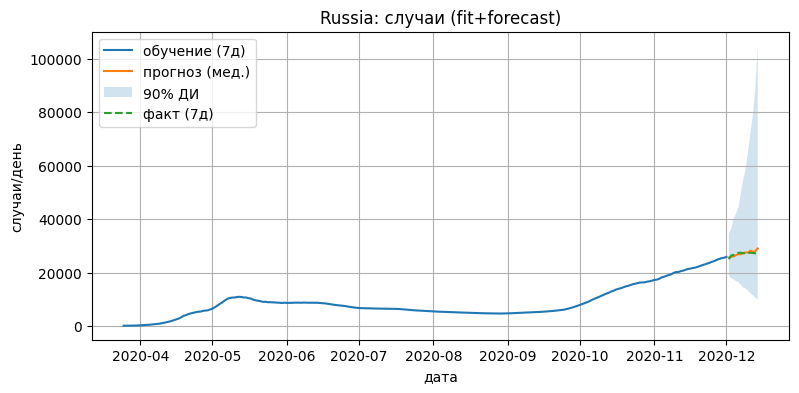

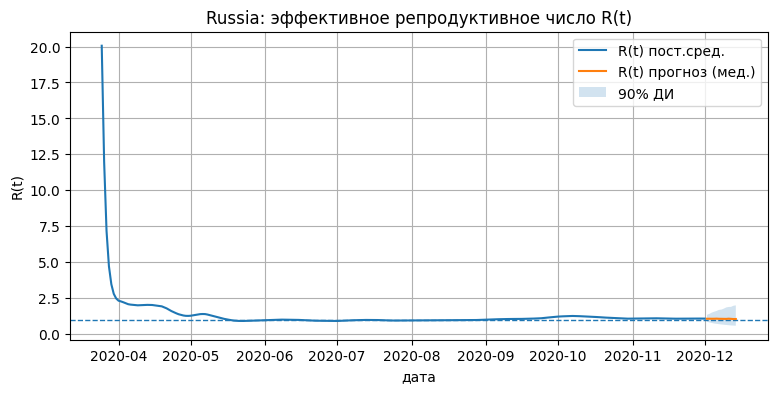

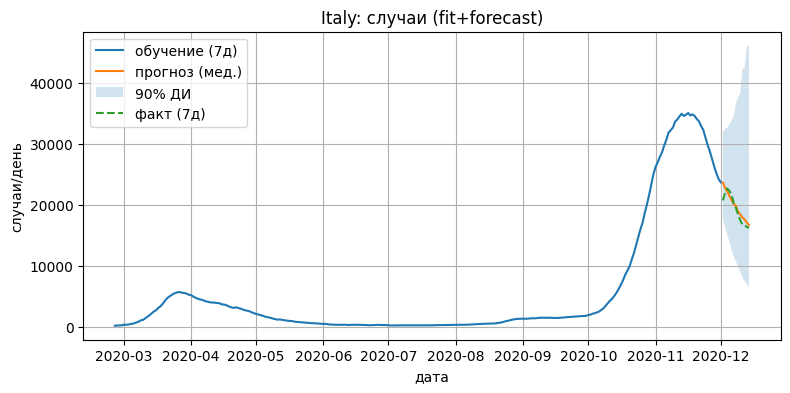

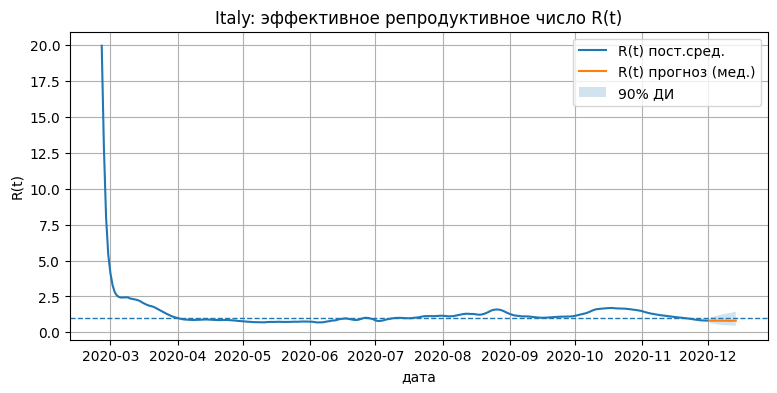

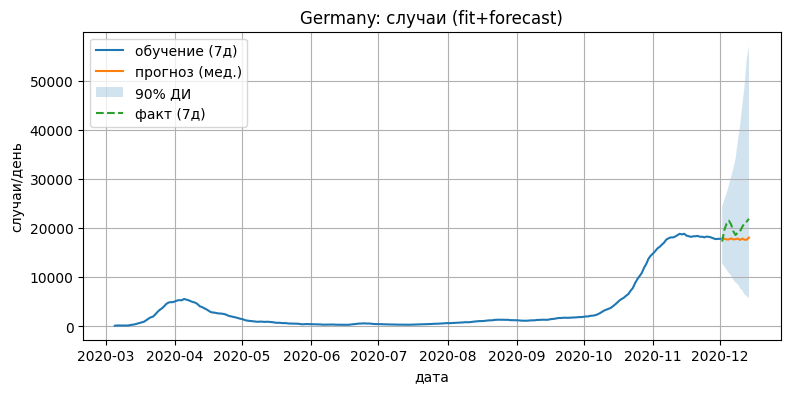

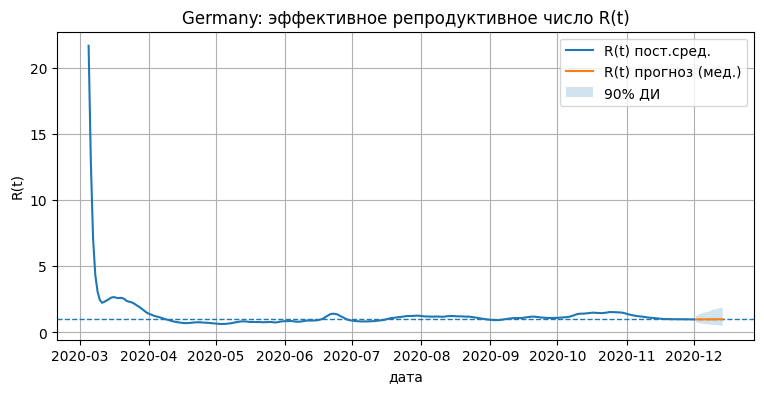

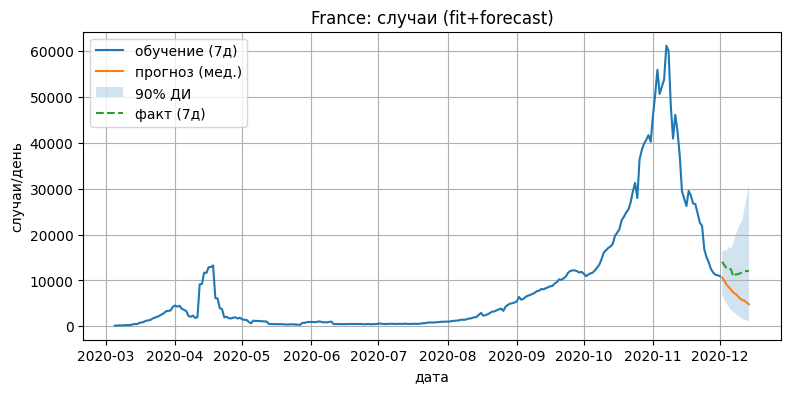

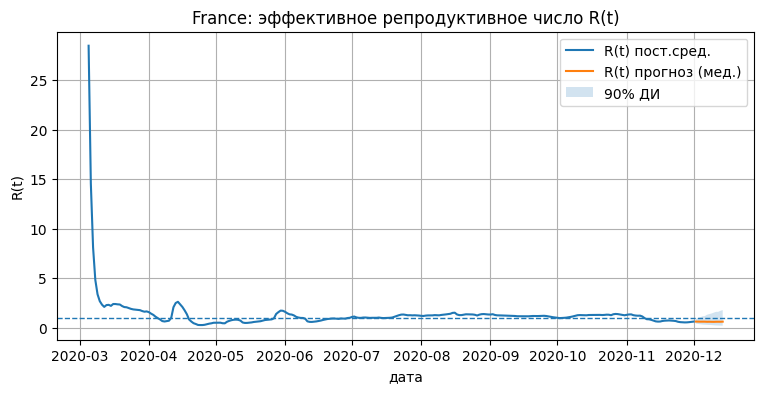

In [8]:
results = {}
tables = []

horizon = (end_fc - start_fc).days + 1   # 13 дней

for cname in countries:
    print(f"=== {cname} ===")
    d = series[cname]
    idata = fit_country(cname, d, draws=800, tune=800)
    fc = forecast_country(idata, d, horizon=horizon)
    results[cname] = (d, idata, fc)

    real = (df_real[df_real.location.eq(cname)]
            .set_index("date").sort_index())
    q = fc["cases_q"]
    report = pd.DataFrame({
        "date": fc["dates"],
        "pred_p05": q[0],
        "pred_p50": q[1],
        "pred_p95": q[2],
        "real_new_cases": real["new_cases"].reindex(fc["dates"]).values
    })
    tables.append((cname, report))

for cname, report in tables:
    print("\n", cname)
    print(report.round(1).head(7).to_string(index=False))

for cname in countries:
    d, idata, fc = results[cname]
    plot_country(cname, d, idata, fc, df_real)


1. построил простую байесовскую стохастическую модель распространения COVID-19 на базе renewal-уравнения. В ней эффективное репродуктивное число (R(t)) эволюционирует как гауссовское случайное блуждание (Gaussian Random Walk), а наблюдаемые случаи моделируются отрицательно-биномиальным распределением, чтобы учитывать избыточную дисперсию.

2. Обучена модель для России, Италии, Германии и Франции на данных Our World in Data за период 01.01.2020–01.12.2020. Для каждой страны я отбросил дни до первого превышения 100 случаев в день, чтобы не подгонять модель под шум раннего завоза, и использовал 7-дневное сглаживание.

3. Оценённые траектории (R(t)) показывают, что после начальных всплесков в начале эпидемии (R(t)) держится около единицы. Это соответствует интуиции: эпидемия не исчезает, но и не уходит в долгий неуправляемый рост — меры вмешательства периодически возвращают (R(t)) к 1.

4. В прогнозе на 02.12.2020–14.12.2020 по новым случаям и по (R(t)) реальные значения по странам в большинстве случаев попадают в 90%-доверительный интервал, а медианы предсказаний близки к фактическим уровням. На практике даже такая базовая модель даёт осмысленный краткосрочный (порядка двух недель) прогноз.
